<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/cell_wall_deformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 力学試験におけるヒノキ断面の構造的変化の定量的解析
![picture 0](https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/1d74d56b7a8c2206b0ae02a96dee380a4a13a57d5f8001718ed48ff9aae66738.png)  
Chen et al., 2022より転載
## ライセンス
- Chen, S., Awano, T., Yoshinaga, A., & Sugiyama, J. (2022). Flexural behavior of wood in the transverse direction investigated using novel computer vision and machine learning approach. Holzforschung, 76(10), 875–885. https://doi.org/10.1515/hf-2022-0096
    - CC-BY-4.0
- 公式レポジトリ
    - https://github.com/pywood21/holz_202209
- データセット
    - https://repository.kulib.kyoto-u.ac.jp/dspace/handle/2433/287077
    - https://doi.org/10.14989/287077
- Smooth blend image patches
    - https://github.com/Vooban/Smoothly-Blend-Image-Patches
    - MIT
    
## 解説
力学試験において、木材の細胞レベルでの組織変化を解析することで、その材質の力学特性を理解することが可能です。Chenらの研究では、ヒノキの木材を用いた曲げ試験中の断面画像に、U-Netに基づくセマンティックセグメンテーションを適用しました。これにより画像中の細胞壁が強調され、細胞の形状を正確に定量化することができました。さらに、時系列に基づく画像解析を通じて、材質の変形分布を高精度に分析することが可能となります。

## 環境設定

In [9]:
!pip install -q mahotas trackpy

In [10]:
PROJECT_PATH = "/content/drive/MyDrive/cell_wall_deformation"

In [11]:
!cp {os.path.join(PROJECT_PATH, "utils", "smooth_tiled_predictions.py")}  ./
!cp {os.path.join(PROJECT_PATH, "utils", "cell_wall_deformation_analysis_func.py")}  ./
!cp {os.path.join(PROJECT_PATH, "utils", "kmeans_clustering_func.py")}  ./

In [12]:
import os
import cv2

import numpy as np
import pandas as pd
import trackpy as tp
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.util import montage
from skimage.filters import threshold_otsu
import tensorflow as tf

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from sklearn.cluster import KMeans

力学試験画像データセットをみてみましょう

データは N sec .jpgという命名規則となっています。時系列順にファイルリストを並び替えましょう。

In [13]:
IMG_DIR = os.path.join(PROJECT_PATH, "data", "large_image_sample")
files = [x for x in os.listdir(IMG_DIR) if x.endswith(".jpg")]
print("before", files[:10])
sec = [int(x.split(" ")[0]) for x in files]
idx = np.argsort(np.array(sec))
files = np.array(files)[idx]
print("sec sorted", files[:10])

before ['141 sec .jpg', '45 sec .jpg', '26 sec .jpg', '17 sec .jpg', '37 sec .jpg', '140 sec .jpg', '163 sec .jpg', '164 sec .jpg', '150 sec .jpg', '183 sec .jpg']
sec sorted ['0 sec .jpg' '1 sec .jpg' '2 sec .jpg' '3 sec .jpg' '4 sec .jpg'
 '5 sec .jpg' '6 sec .jpg' '7 sec .jpg' '8 sec .jpg' '9 sec .jpg']


時系列画像をmontageで１つにまとめ、表示させます。

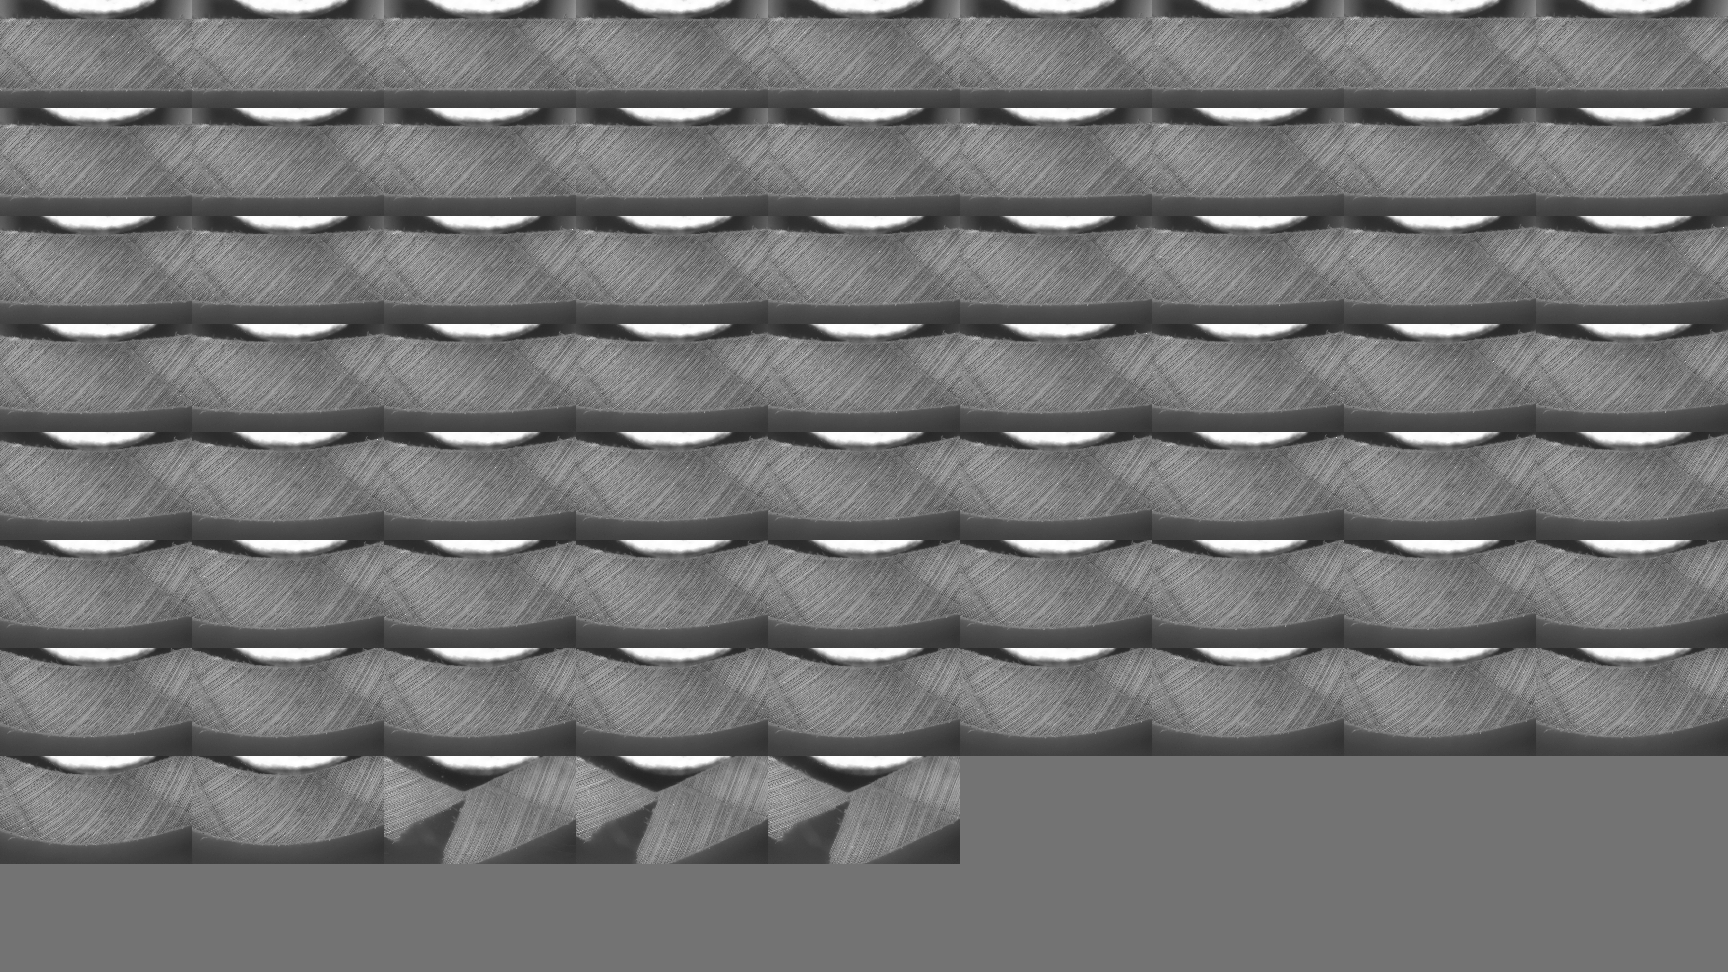

In [14]:
frames = []
for file in files:
    path = os.path.join(IMG_DIR, file)
    image = cv2.imread(path, 0)
    image = cv2.resize(image, dsize=None, fx=0.1, fy=0.1)
    frames.append(image)


_frames = montage(frames[::3])
cv2_imshow(_frames)

時間の経過とともに材質の歪みと破断が起きていることがわかります。
今度は画像を拡大して表示してみましょう。


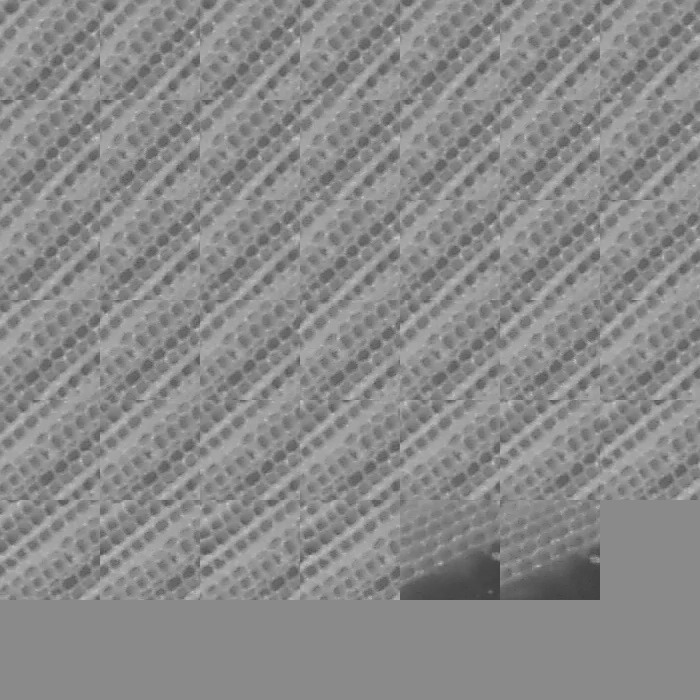

In [15]:
frames = []
for file in files:
    path = os.path.join(IMG_DIR, file)
    image = cv2.imread(path, 0)[500:600,500:600]
    frames.append(image)
_frames = montage(frames[::5])
cv2_imshow(_frames)

これまでの画像解析のように閾値をもとにマスク画像変換し、細胞壁とそれ以外を区別すれば、細胞の形が定量できるかもしれません。
ただし、コントラストやピントの問題から、上述のような画像そのままでは難しいことが予想されます。

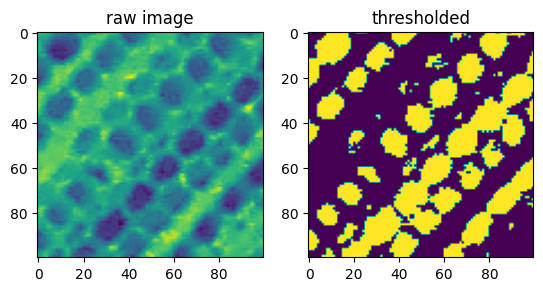

In [16]:
file = files[0]
path = os.path.join(IMG_DIR, file)
image = cv2.imread(path, 0)[500:600,500:600]
thresh = threshold_otsu(image)
binary = image < thresh

plt.subplot(1,2,1)
plt.title("raw image")
plt.imshow(image)
plt.subplot(1,2,2)
plt.title("thresholded")
plt.imshow(binary)
plt.show()

やはり、細胞の領域単離がうまくいきません。

tensorflow.kerasのhdf5形式のモデルファイルを読み込みます。

## 推論

In [17]:
model_path = os.path.join(PROJECT_PATH,"model.hdf5")
model = tf.keras.models.load_model(model_path)

In [18]:
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_24/Sigmoid:0', description="created by layer 'conv2d_24'")


256x256の単一チャンネル画像を入力とし、同サイズの画像を出力するモデルであることが確認できます。

今回の深層学習モデルが、どのようなセマンティックセグメンテーションを行うか、確認してみましょう。

1/1 [==============================] - 3s 3s/step


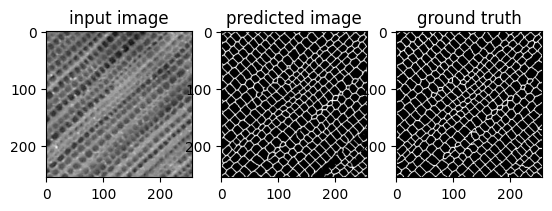

In [19]:
val_dir = os.path.join(PROJECT_PATH, "data","validation")
files = os.listdir(os.path.join(val_dir, "image"))
file = files[0]
path = os.path.join(val_dir,"image", file)
image = cv2.imread(path,0)
image = cv2.resize(image, dsize=(256,256))/255.

inputs = image.copy()
inputs = np.expand_dims(inputs, 0)
inputs = np.expand_dims(inputs, -1)
pred = model.predict(inputs)[0]

gt_path = os.path.join(val_dir, "label",file)
gt = cv2.imread(gt_path, 0)

plt.subplot(1,3,1)
plt.title("input image")
plt.imshow(image, cmap="gray")
plt.subplot(1,3,2)
plt.title("predicted image")
plt.imshow(pred, cmap="gray")
plt.subplot(1,3,3)
plt.title("ground truth")
plt.imshow(gt, cmap="gray")
plt.show()

推論の結果、細胞壁の輪郭が強調されてノイズが軽減されました。このような画像であれば、例えば以下のような簡単な処理でさえも、細胞の形を高精度に解析することを可能となります。

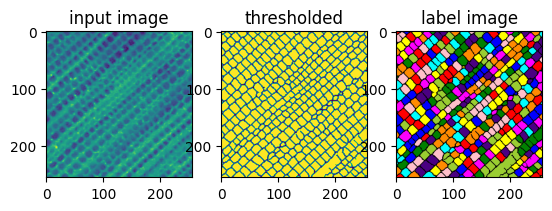

In [25]:
thresh = threshold_otsu(pred)
binary = pred < thresh
lbl_image = label(binary)
lbl_color_image = label2rgb(lbl_image[...,0])

plt.subplot(1,3,1)
plt.title("input image")
plt.imshow(image)
plt.subplot(1,3,2)
plt.title("thresholded")
plt.imshow(binary)
plt.subplot(1,3,3)
plt.title("label image")
plt.imshow(lbl_color_image)
plt.show()

それでは解析対処の画像を改めて確認してみましょう。

(1080, 1920, 1)


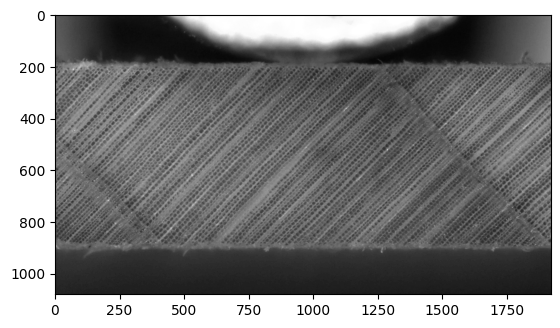

In [ ]:
IMG_DIR = os.path.join(PROJECT_PATH, "data", "large_image_sample")
files = sorted([x for x in os.listdir(IMG_DIR) if x.endswith(".jpg")])
file = files[0]
path = os.path.join(IMG_DIR, file)
image = cv2.imread(path, 0)
image = np.expand_dims(image, -1)/255.
plt.imshow(image, cmap="gray")
print(image.shape)  # (1080,1920,1)


今回扱うU-Netモデルは256x256の画像を推論するように訓練されています。しかし、推論したい画像の大きさは1080x1920であり、モデルと適合しません。このような場合、一つの方法として、画像を分割し、それぞれの切り抜きをモデルで推論した後、元の大きさの画像に再構成する手法があります。切り抜いた画像同士をどのように重ね合わせて融合させるかがポイントとなり、開発者によって異なるアプローチが取られます。今回は、筆者らが採用したChevaierら（2017）によるpatch blending algorithmを利用します。


推論関数を直接pred_funcとして受け渡すことで推論結果を戻値として得ることができます。

In [ ]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

def prediction(x):
    x = model.predict(x)
    return x

predictions_smooth = predict_img_with_smooth_windowing(
    image,
    window_size=256,
    subdivisions=2,
    nb_classes=1,
    pred_func= prediction
)

  0%|          | 0/8 [00:00<?, ?it/s]

5/5 [==============================] - 37s 4s/step


 12%|█▎        | 1/8 [00:42<04:55, 42.28s/it]

5/5 [==============================] - 2s 619ms/step


 25%|██▌       | 2/8 [00:48<02:07, 21.18s/it]

5/5 [==============================] - 2s 610ms/step


 38%|███▊      | 3/8 [00:55<01:12, 14.45s/it]

5/5 [==============================] - 2s 600ms/step


 50%|█████     | 4/8 [01:01<00:45, 11.28s/it]

5/5 [==============================] - 2s 599ms/step


 62%|██████▎   | 5/8 [01:07<00:28,  9.52s/it]

5/5 [==============================] - 2s 604ms/step


 75%|███████▌  | 6/8 [01:12<00:15,  7.68s/it]

5/5 [==============================] - 2s 601ms/step


 88%|████████▊ | 7/8 [01:16<00:06,  6.54s/it]

5/5 [==============================] - 2s 605ms/step


100%|██████████| 8/8 [01:20<00:00, 10.07s/it]


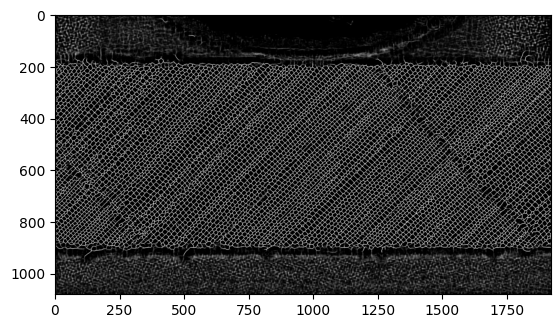

In [ ]:
plt.imshow(predictions_smooth,cmap="gray")
plt.show()

## 細胞変形解析

時系列画像193枚推論を行うのは時間がかかります。推論結果（uint8型の細胞壁が黒、細胞領域後が白であるnpyファイル）が提供されているため、そちらを読み出します。

(193, 1080, 1920)


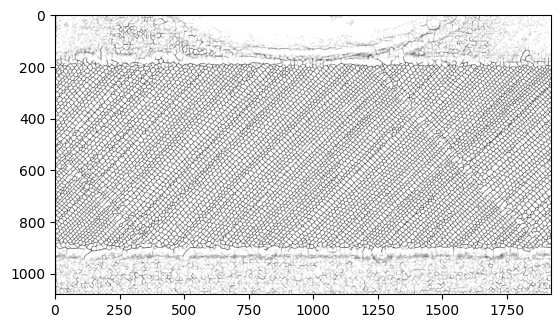

In [ ]:
# if resume, start from here
predictions = np.load(os.path.join(PROJECT_PATH, "data", "processed", "image_sequence.npy"))
print(predictions.shape)  # (193,1080,1920)
plt.imshow(predictions[0], cmap="gray")
plt.show()

後処理のプログラムコードの殆どは論文著者ら提供のcell_wall_deformation_analysis_func.pyに記述されています。

以下のセル内で使用されるanalyzerクラスでは、以下の処理を行います。

1. label と regionprops を使用して細胞領域の特徴抽出を行う。
2. regionprops から、各領域の中心座標（centroid）を取得する。
3. ラベル付けされた画像において、各細胞に対応する領域番号とcentroid座標を抽出し、これらを時系列画像全体にわたるデータフレームにまとめる。
4. 粒子解析ライブラリである trackpy を使用し、centroid座標を基にして時系列画像間での同一細胞領域を同定する。
5. 全フレームにおいて対応がつく細胞領域のみを抽出する。
抽出された各細胞領域について、各画像での形状（面積、偏心率、主軸長、副軸長、アスペクト比、バウンディングボックスのアスペクト比）を regionprops から算出する。


解析に10~15分程度かかります。解析結果はnpyファイルとして提供されているので次のnp.loadのセルまで飛ばしても構いません。

In [ ]:
import cell_wall_deformation_analysis_func as cwdaf

analyzer = cwdaf.analyzer(predictions)
cell_list, centroids_x_list, \
    centroids_y_list, frame_num_list, \
    labels_list = analyzer.extract_feature()

track_result_filtered, cell_true, \
    check_number = analyzer.tracker(
        cell_list, centroids_x_list, centroids_y_list,
        frame_num_list, labels_list)

area_change_lists_array, ecc_change_lists_array, \
    aspect_axis_change_lists_array, \
    aspect_bbox_change_lists_array = \
        analyzer.parameter_changes_cal(
            cell_true, check_number, num=5)

Frame 192: 13413 trajectories present.


100%|██████████| 189/189 [01:32<00:00,  2.05it/s]


以下がtrackpyを使用した同一粒子（細胞）の同定結果です。particle列の同じ値は、時系列画像間における同一細胞を意味します。

In [ ]:
track_result_filtered

,y,x,frame,label,particle
10294,841.089722,362.378204,0,10295.0,4
10296,843.344299,532.216125,0,10297.0,6
10297,842.151062,604.682312,0,10298.0,7
10298,842.733337,621.019043,0,10299.0,8
10299,841.975403,883.995911,0,10300.0,9
...,...,...,...,...,...
2790507,438.758942,94.133926,192,4473.0,13322
2790508,439.508972,350.203583,192,4474.0,12386
2790509,440.000000,574.061523,192,4475.0,14846
2790510,443.096436,631.657166,192,4476.0,14885


例えば、以下はparticle id 4に対応する細胞領域の各画像における位置をあらわします。

In [ ]:
track_result_filtered[track_result_filtered["particle"]==4]

,y,x,frame,label,particle
10294,841.089722,362.378204,0,10295.0,4
26084,841.068298,361.962738,1,10637.0,4
42124,840.824341,361.804047,2,10852.0,4
57878,840.425781,362.109680,3,10862.0,4
74131,840.886230,362.011963,4,10569.0,4
...,...,...,...,...,...
2740472,814.369934,290.826599,188,8406.0,4
2753940,814.219482,289.884155,189,8411.0,4
2767044,814.061768,289.876404,190,8295.0,4
2780737,813.947693,289.523254,191,8375.0,4


trackpyの可視化機能で、解析できた全細胞の変異（=trajectory)を確認することができます。

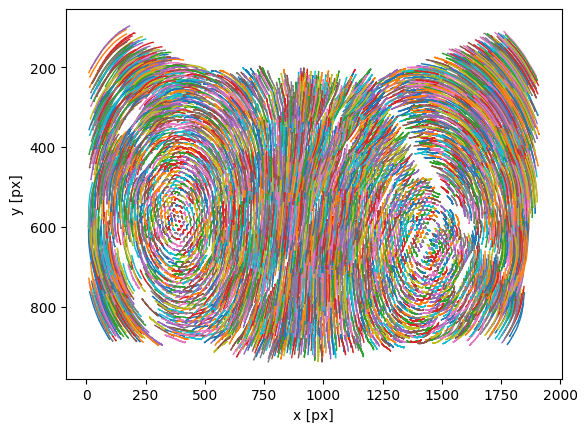

In [ ]:
tp.plot_traj(track_result_filtered);

力点を中心に左右対称のらせん状の細胞の動き（材質の変異）があることが示唆されます。

In [ ]:
# np.savez_compressed(os.path.join(PROJECT_PATH, "data", "processed", "deformation_analysis_complete.npz"),
#                     area_change=area_change_lists_array,
#                     ecc_change=ecc_change_lists_array,
#                     aspect_axis_change=aspect_axis_change_lists_array,
#                     aspect_bbox_change=aspect_bbox_change_lists_array,
#                     track_result_filtered=track_result_filtered,
#                     cell_true=cell_true)

ただし、今回は力学試験であり、細胞の移動量や方向ではなく、変形度合いに着目する必要があります。analyzerクラスに実装されているresult_visualizeメソッドを使い、個々の細胞の変形度合いを、アスペクト比の時系列変化を用いて可視化します。

In [ ]:
# if resume, start from here
import cell_wall_deformation_analysis_func as cwdaf

predictions = np.load(os.path.join(PROJECT_PATH, "data", "processed", "image_sequence.npy"))
data = np.load(os.path.join(PROJECT_PATH, "data", "processed", "deformation_analysis_complete.npz"))

area_change_lists_array = data['area_change']
ecc_change_lists_array = data['ecc_change']
aspect_axis_change_lists_array = data['aspect_axis_change']
aspect_bbox_change_lists_array = data['aspect_bbox_change']
_df = data["track_result_filtered"]
track_result_filtered = pd.DataFrame(_df, columns=["y",	"x", "frame", "label", "particle"])
track_result_filtered["frame"] = track_result_filtered["frame"].astype(int)
cell_true = data['cell_true']

In [ ]:
analyzer = cwdaf.analyzer(predictions)
result_aspect_axis_change_rate_map = analyzer.result_visualize(
    cell_true, track_result_filtered, aspect_axis_change_lists_array)

100%|██████████| 189/189 [03:16<00:00,  1.04s/it]


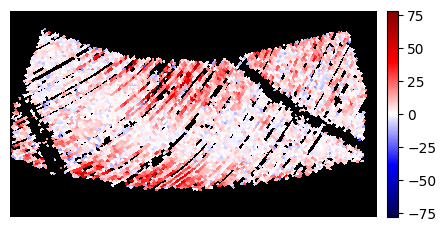

In [ ]:
num = -1
dsiplay = np.nan_to_num(result_aspect_axis_change_rate_map, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

lim_min = np.max(np.abs(dsiplay[:,:,num]))*-1
lim_max = np.max(np.abs(dsiplay[:,:,num]))

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_yaxis()

divider = cwdaf.make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cm = plt.cm.seismic.copy()
cm.set_bad((0, 0, 0, 1))

mesh = ax.pcolormesh(np.ma.array(dsiplay[:,:,num], mask=cell_true[:,:,num]==0), cmap = cm)
mesh.set_clim(lim_min,lim_max)

fig.colorbar(mesh,cax=cax)

赤や青が細胞のアスペクト比の変化が著しい箇所です。変形している箇所を可視化・特定することができました。

In [ ]:
# np.savez_compressed('./map.npz',
#                     cell = cell_true[:,:,4:],
#                     aspect_axis_change = result_aspect_axis_change_rate_map)

## 最後に
## k-meansクラスタリングによる細胞変形パターンの分類
細胞のアスペクト比の変化量をk-meansクラスタリングにかけることで、変化パターンに応じて細胞をグループ化します。

In [ ]:
# if resume, start from here
import cell_wall_deformation_analysis_func as cwdaf
import kmeans_clustering_func as kcf

lists = np.load(os.path.join(PROJECT_PATH, "data", "processed", "deformation_analysis_complete.npz"))
mapping = np.load(os.path.join(PROJECT_PATH, "data", "processed", "map.npz"))

cell_true = mapping['cell']
lists_array = lists['aspect_axis_change']

df_change_lists = kcf.processer.make_particle_change_lists(lists_array, num_list=True)
selected_lists, original_p_n_lists, modified_p_n_lists = kcf.processer.modify_change_lists(df_change_lists, 1000, -1000)
cell_true_trans = kcf.processer.transform_cell_true(cell_true, original_p_n_lists, modified_p_n_lists)

100%|██████████| 5272/5272 [00:00<00:00, 36086.98it/s]


In [ ]:
df_mod = pd.DataFrame(selected_lists)
num_clusters = 8
HR_kmeans = KMeans(n_clusters=num_clusters, random_state=0)
HR_model = HR_kmeans.fit(df_mod.iloc[:,1:])
HR_kmeans_result = HR_model.predict(df_mod.iloc[:,1:])
HR_kmeans_map = kcf.processer.result_visualization_kmeans(cell_true_trans, HR_kmeans_result)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


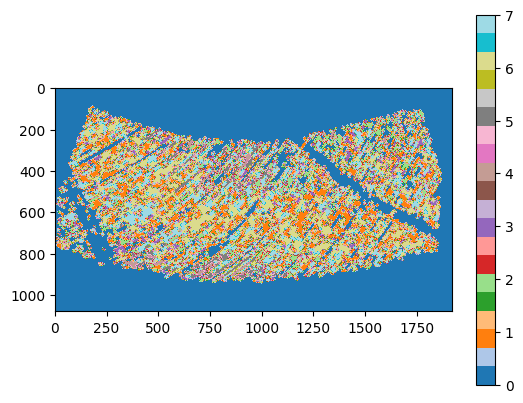

In [ ]:
plt.imshow(HR_kmeans_map,cmap="tab20")
plt.colorbar()